In [1]:
import yaml
import sys
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from keras import backend as K
from collections import OrderedDict
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from evml.reliability import compute_calibration, reliability_diagram, reliability_diagrams
from evml.plotting import plot_confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.tensorflow import balanced_batch_generator

2022-09-30 13:27:35.181036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 13:27:35.456843: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-30 13:27:35.497382: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 13:27:37.333545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
config = "../config/p-type.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [3]:
def build_model(input_size, 
                hidden_size, 
                num_hidden_layers, 
                output_size, 
                activation, 
                dropout_rate):
    
    model = tf.keras.models.Sequential()
        
    if activation == 'leaky':
        model.add(tf.keras.layers.Dense(input_size))
        model.add(tf.keras.layers.LeakyReLU())
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
            else:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
                model.add(tf.keras.layers.Dropout(dropout_rate))
    else:
        model.add(tf.keras.layers.Dense(input_size, activation=activation))
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
            else:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
                model.add(tf.keras.layers.Dropout(dropout_rate))
        
    model.add(tf.keras.layers.Dense(output_size, activation='softmax'))
    
    return model

In [4]:
if not os.path.isfile(os.path.join(conf['data_path'], "cached.parquet")):
    df = pd.concat([
        pd.read_parquet(x) for x in tqdm.tqdm(glob.glob(os.path.join(conf['data_path'], "*.parquet")))
    ])
    df.to_parquet(os.path.join(conf['data_path'], "cached.parquet"))
else:
    df = pd.read_parquet(os.path.join(conf['data_path'], "cached.parquet"))

### Split and preprocess the data
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])
df["id"] = range(df.shape[0])

test_days = [f"2021-02-{k}" for k in range(10, 20)] #texas
test_days += ["2022-02-03", "2022-02-04"] # New York
test_days += [f"2017-03-{k}" for k in range(11, 18)] # NE NorEaster
test_days += [f"2016-12-{k}" for k in range(15, 21)]
test_days_c = df["day"].isin(test_days)

In [5]:
# Need the same test_data for all trained models (data and model ensembles)
#n_splits = 10
data_seed = 0
flat_seed = 1000
gsp = GroupShuffleSplit(n_splits=conf["trainer"]["n_splits"],
                        random_state = flat_seed, 
                        train_size=conf["trainer"]["train_size1"])
splits = list(gsp.split(df[~test_days_c], groups = df[~test_days_c]["day"]))
train_index, test_index = splits[0]
train_data, test_data = df[~test_days_c].iloc[train_index].copy(), df[~test_days_c].iloc[test_index].copy() 
test_data = pd.concat([test_data, df[test_days_c].copy()])

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=conf["trainer"]["n_splits"],
                        random_state = flat_seed, 
                        train_size=conf["trainer"]["train_size2"])
splits = list(gsp.split(train_data, groups = train_data["day"]))

train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy() 

In [6]:
#train_data.shape, valid_data.shape, test_data.shape

In [7]:
train_data.shape[0] / df.shape[0], test_data.shape[0] / df.shape[0]

(0.7998376984940802, 0.10034246499822483)

In [8]:
features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
outputs = conf['outputvars']
num_classes = len(outputs)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[features])
x_valid = scaler_x.transform(valid_data[features])
x_test = scaler_x.transform(test_data[features])
y_train = tf.keras.utils.to_categorical(np.argmax(train_data[outputs].to_numpy(), 1), num_classes)
y_valid = tf.keras.utils.to_categorical(np.argmax(valid_data[outputs].to_numpy(), 1), num_classes)
y_test = tf.keras.utils.to_categorical(np.argmax(test_data[outputs].to_numpy(), 1), num_classes)

In [57]:
train_idx = np.argmax(train_data[outputs].to_numpy(), 1)
weights = np.array([1., 1., 0.5, 0.5])

training_generator, steps_per_epoch = balanced_batch_generator(
    x_train,
    y_train,
    sample_weight=np.array([weights[l] for l in train_idx]),
    sampler=RandomUnderSampler(),
    batch_size=conf["trainer"]["batch_size"],
    random_state=flat_seed,
)

In [58]:
try:
    del mlp
    K.clear_session()
    gc.collect()
except:
    pass

In [59]:
mlp = build_model(len(features), 
                  conf["trainer"]["hidden_sizes"], 
                  conf["trainer"]["num_hidden_layers"], 
                  len(outputs), 
                  conf["trainer"]["activation"], 
                  conf["trainer"]["dropout_rate"])

mlp.build((conf["trainer"]["batch_size"], len(features)))
mlp.summary()

#mlp = MLP(hidden_size, dropout, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (2048, 268)               72092     
                                                                 
 leaky_re_lu (LeakyReLU)     (2048, 268)               0         
                                                                 
 dense_1 (Dense)             (2048, 128)               34432     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (2048, 128)               0         
                                                                 
 dropout (Dropout)           (2048, 128)               0         
                                                                 
 dense_2 (Dense)             (2048, 128)               16512     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (2048, 128)               0

In [60]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=conf["trainer"]["learning_rate"]
)

In [61]:
criterion = "categorical_crossentropy"

# compile model
mlp.compile(
    optimizer = optimizer, 
    loss = criterion,
    metrics = ["accuracy",
               tf.keras.metrics.Precision(name="prec"),
               tf.keras.metrics.Recall(name="recall"),
               tfa.metrics.F1Score(num_classes=num_classes,
                                   average='macro', name="f1")]
    #run_eagerly=True
)

In [62]:
# create early stopping callback
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_f1', 
    mode = 'max',
    patience = 15,
    restore_best_weights = True
)

# create reduce LR callback
callback2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_f1', 
    factor = 0.1, 
    patience = 3, 
    verbose = 0,
    mode = 'max',
    min_lr = 1e-7
)

In [63]:
# fit model to training data
history = mlp.fit(
    training_generator, 
    steps_per_epoch=steps_per_epoch,
    #x = x_train, 
    #y = y_train,
    validation_data = (x_valid, y_valid),
    batch_size = conf["trainer"]["batch_size"],
    #class_weight = {k: v for k, v in enumerate(conf["trainer"]["outputvar_weights"])},
    epochs = 1000,
    callbacks = [callback1, callback2],
    verbose = 2,
    shuffle = True
)

Epoch 1/1000
14/14 - 1s - loss: 0.8111 - accuracy: 0.4944 - prec: 0.5876 - recall: 0.3706 - f1: 0.4684 - val_loss: 0.5434 - val_accuracy: 0.7993 - val_prec: 0.9046 - val_recall: 0.7009 - val_f1: 0.5730 - lr: 0.0010 - 1s/epoch - 85ms/step
Epoch 2/1000
14/14 - 0s - loss: 0.6071 - accuracy: 0.6050 - prec: 0.7006 - recall: 0.4659 - f1: 0.5848 - val_loss: 0.5160 - val_accuracy: 0.8097 - val_prec: 0.9171 - val_recall: 0.7153 - val_f1: 0.5997 - lr: 0.0010 - 184ms/epoch - 13ms/step
Epoch 3/1000
14/14 - 0s - loss: 0.5603 - accuracy: 0.6356 - prec: 0.7279 - recall: 0.5014 - f1: 0.6162 - val_loss: 0.4719 - val_accuracy: 0.8245 - val_prec: 0.9038 - val_recall: 0.7570 - val_f1: 0.6179 - lr: 0.0010 - 178ms/epoch - 13ms/step
Epoch 4/1000
14/14 - 0s - loss: 0.5389 - accuracy: 0.6526 - prec: 0.7368 - recall: 0.5308 - f1: 0.6359 - val_loss: 0.4559 - val_accuracy: 0.8294 - val_prec: 0.9012 - val_recall: 0.7681 - val_f1: 0.6223 - lr: 0.0010 - 177ms/epoch - 13ms/step
Epoch 5/1000
14/14 - 0s - loss: 0.5226 

In [64]:
preds = mlp.predict(x_test)

1422/1422 [==============================] - 1s 930us/step


In [65]:
true_labels = np.argmax(test_data[outputs].to_numpy(), 1)
pred_labels = np.argmax(preds, 1)
confidences = np.take_along_axis(
    preds,
    pred_labels[:, None], 
    axis=1
)

test_data["true_labels"] = true_labels
test_data["pred_labels"] = pred_labels
test_data["pred_conf"] = confidences
test_data["accuracy"] = (test_data["pred_labels"] == test_data["true_labels"]).to_numpy()

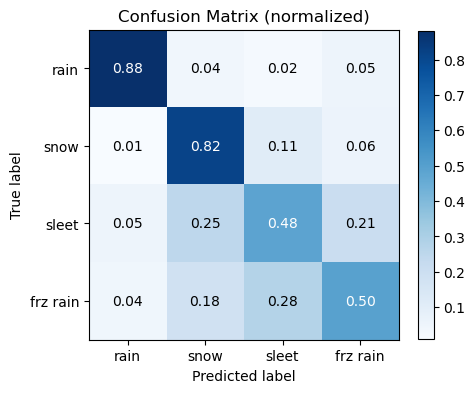

In [66]:
plot_confusion_matrix(test_data["true_labels"], 
                      test_data["pred_labels"], 
                      ["rain", "snow", "sleet", "frz rain"], 
                      "MLP", 
                      normalize=True,
                      title=f'Confusion Matrix (normalized)')#, filename='cm_norm.png')

plt.show()

In [67]:
results_calibration = compute_calibration(
    true_labels, 
    pred_labels, 
    confidences, 
    num_bins=10)

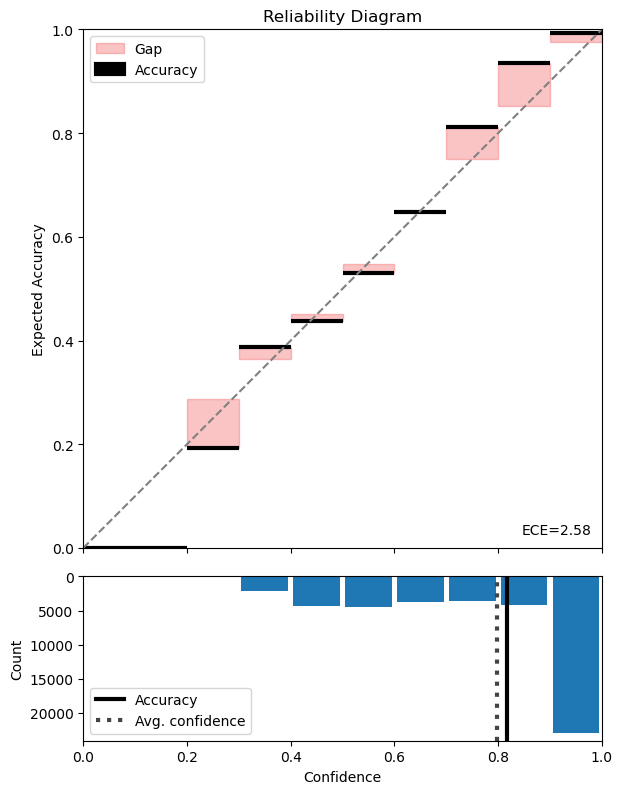

In [68]:
reliability_diagram(
    true_labels, 
    pred_labels, 
    confidences, 
    num_bins=10, dpi=100)

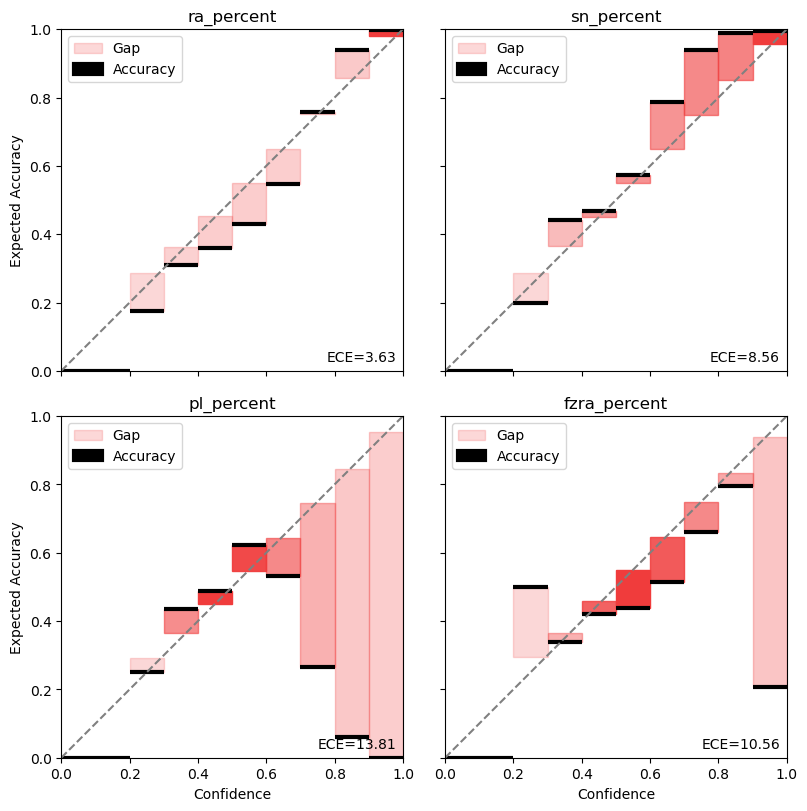

In [69]:
results = OrderedDict()
for label in range(num_classes):
    cond = (test_data["true_labels"] == label)
    results[outputs[label]] = {
        "true_labels": test_data[cond]["true_labels"].values, 
        "pred_labels": test_data[cond]["pred_labels"].values, 
        "confidences": test_data[cond]["pred_conf"].values
    }
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha",
                           num_cols=2, dpi=100, return_fig=True)

In [70]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

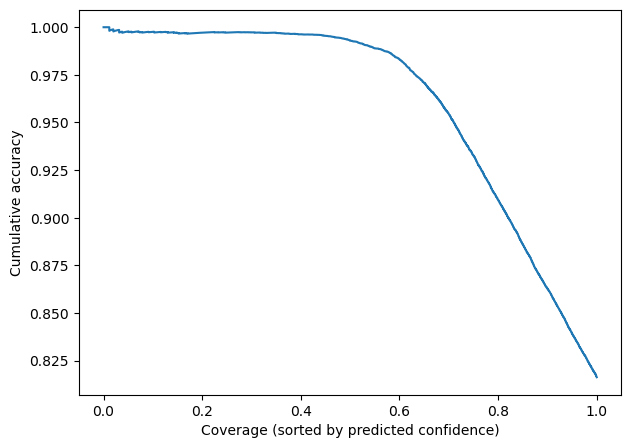

In [71]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
    
_test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "accuracy")
ax.plot(
    _test_data_sorted["pred_conf_cov"],
    _test_data_sorted["cu_accuracy"]
)
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted confidence)")
plt.show()

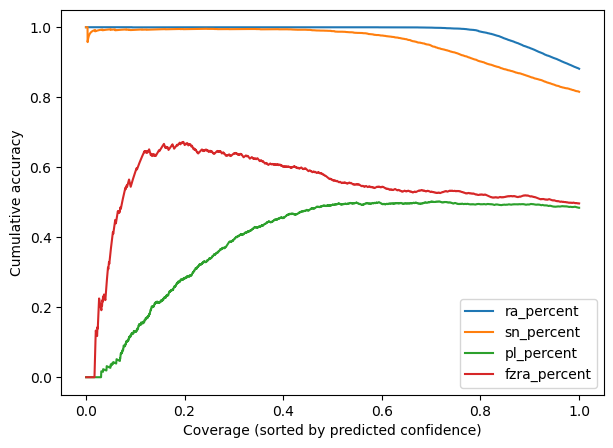

In [72]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
    
for label in range(num_classes):
    cond = (test_data["true_labels"] == label)
    _test_data_sorted = compute_cov(test_data[cond], col = "pred_conf", quan = "accuracy")
    ax.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_accuracy"]
    )
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted confidence)")
plt.legend(outputs)
plt.show()